# **Support Vector Machines** #

**Classification**

**Imports**

In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

**Loading Dataset**

In [224]:
df = pd.read_csv("Bank Customer Churn Prediction.csv")

df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Checking for duplicates**

In [225]:
df.duplicated().sum()

0

**Checking for missing values**

In [226]:
df.isna().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

**Dropping Unnecessary columns** 

In [227]:
#Dropping customer_id as it doesnt have any effect on results 
df = df.drop("customer_id", axis=1)

In [228]:
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Handling Categorical Variables**

We will convert the gender into Binary using Label Encoder

In [229]:
#converting the value of column to 0 or 1
from sklearn.preprocessing import LabelEncoder

variables = ['gender']

encoder = LabelEncoder()
df[variables] = df[variables].apply(encoder.fit_transform)

We will convert the country into Nominal variable using OneHotEncoder

In [230]:
from sklearn.preprocessing import OneHotEncoder

variables = ['country']

encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

In [231]:
df = df.drop("country_France", axis=1)
df.head()

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_Germany,country_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,0,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,1


**Balancing Dataset**

we will balance the dataset to overcome the imbalance of minority class

In [232]:

from imblearn.over_sampling import SMOTE

X = df.drop('churn', axis=1)
y = df['churn']

smote = SMOTE(sampling_strategy=0.5, random_state=42)  
X_res, y_res = smote.fit_resample(X, y)




**Train/Test Split**

In [233]:
#Defining the dataset into X & Y 

X = df.drop(["churn"], axis=1)
y = df[["churn"]]

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42,
stratify=y_res
)


**Scalling**

In [234]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

**RandomizedSearchCV**

we will use RandomizedSearchCV to find the best parameters quickly

In [235]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'C': [0.1, 2, 20],
    'gamma': [1, 0.25, 0.1, 0.05, 0.025, 0.01], 
    'kernel': ['rbf', 'linear']
}

test_model = RandomizedSearchCV(svm.SVC(), param_distributions=param_grid, n_iter=30, verbose=3, n_jobs=-1, cv=5, random_state=42)
test_model.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=30, n_jobs=-1,
                   param_distributions={'C': [0.1, 2, 20],
                                        'gamma': [1, 0.25, 0.1, 0.05, 0.025,
                                                  0.01],
                                        'kernel': ['rbf', 'linear']},
                   random_state=42, verbose=3)

In [236]:
print(test_model.best_params_)
print(test_model.best_score_)

{'kernel': 'rbf', 'gamma': 0.1, 'C': 2}
0.8223684210526315


**SVC Model**

In [244]:
model = make_pipeline(StandardScaler(), svm.SVC(C=2, gamma=0.1, kernel='rbf', class_weight='balanced',probability=True))
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=2, class_weight='balanced', gamma=0.1,
                     probability=True))])

**Metrics**

In [245]:
#making test predictions 
predictions = model.predict(X_test)

# printing the classification report based on true values and predictions
print(classification_report(y_test, predictions))

# getting overall accuracy of the model and print it
acc = accuracy_score(y_test, predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.89      0.82      0.85      2389
           1       0.68      0.80      0.74      1195

    accuracy                           0.81      3584
   macro avg       0.79      0.81      0.79      3584
weighted avg       0.82      0.81      0.81      3584


Model overall accuracy: 81.00%


The metrics show 81 percent accuracy which is better than previous model proving that SVC performs better and its handling the imblance pretty well too.

[[1948  441]
 [ 240  955]]


<Axes: >

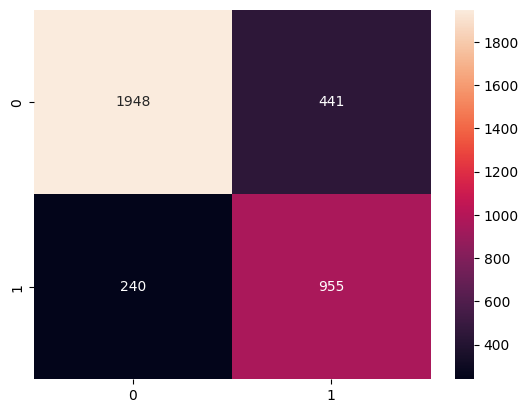

In [246]:
print(confusion_matrix(y_test, predictions))

sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')

In [247]:
#We will check AUC score againsnt the new balanced dataset
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])


0.8846867879454474

ROC AUC score of 0.88 shows that its performing better than previous model.

In [220]:
df.tail()

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_Germany,country_Spain
9995,771,1,39,5,0.00,2,1,0,96270.64,0,0,0
9996,516,1,35,10,57369.61,1,1,1,101699.77,0,0,0
9997,709,0,36,7,0.00,1,0,1,42085.58,1,0,0
9998,772,1,42,3,75075.31,2,1,0,92888.52,1,1,0
9999,792,0,28,4,130142.79,1,1,0,38190.78,0,0,0


In [248]:
# Gender -column: 0 => Female, 1 => Male
tester_row = {
    'credit_score': 771,
    'gender': 1,
    'age': 39,
    'tenure': 5,
    'balance': 0.0,
    'products_number': 2,
    'credit_card': 1,
    'active_member': 0,
    'estimated_salary': 96270.64,
    'country_Germany':0,
    'country_Spain':0

}

# creating a pandas DataFrame and scale the values
tester_row = pd.DataFrame([tester_row])
tester_row = sc.transform(tester_row)

print("All probabilities by category:")
print(model.predict_proba(tester_row))
print()

# change these based on your original data
labels = ["No", "Yes"]

print("Did this person churn (No/Yes):")
result = labels[model.predict(tester_row)[0]]
print(result)
print("-------------------")

All probabilities by category:
[[0.9598876 0.0401124]]

Did this person churn (No/Yes):
No
-------------------


**Summary**

We have imported all the libraries first then we imported the data and checked for duplicates and misssing values and dropped irrelevant coloumn after that we converted non numerical variables such as gender and country as numerical values using LabelEncoder and OneHotEncoder. We balanced the dataset using SMOTE (Synthetic oversampling of minority class) and used RandomizedSearchGrid to find best parameters and  trained the model and checked metrics with previous model to compare and there was improvement in the balance of model and accuracy. ROC AUC for the model showed 88 which is good.

SVC can be useful in real life because it works well with non-linear classifications and can handle imbalance datasets better

The usage was relatively easy.

The model could further be optimised by trying different kernels and handling imbalance more efficiently.

